# 黒ネコ判定機

## 概要
　画像処理および画像判定は、医療分野や土木分野など幅広い分野で利用されています。例えば画像から損傷や欠陥を判定し、効率よく作業を進めるといった活用がされています。また、機械学習による画像認識(例えば顔認証)にも活用されます。
 
　そこで、Pythonによる画像処理および画像判定スキル向上を目的として、ネコ画像を対象に黒ネコ判定機を作成しました。画像処理に有効なOpenCVライブラリを用いて、画像読み込み、マスク処理、輪郭抽出といった基本的な処理を実施し、画素のrgbから黒を判定する機能を実装しました。

　その結果、前提条件を設けた画像に対して精度良く黒ネコを判定する機能を実装することができました。以下、黒ネコ判定機の実装の過程を示します。 

## 目次
- p.2   Case1 画像から黒の割合で判定
- p.4   Case2 背景にマスク処理し黒の割合で判定
- p.7   Case3 輪郭を抽出し輪郭内の色を検査して判定
- p.13 Case4 Case3の機能を複数の画像に対して適用

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

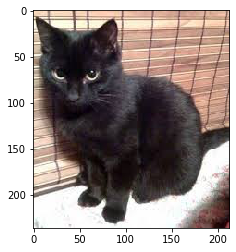

In [2]:
#元画像の表示
img_bgr = cv2.imread('img/kuro_01.jpeg', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb);

### Case1 画像から黒の割合で判定

#### 処理手順
1. 読み込み
2. 2値化し白黒に分ける
3. 白のピクセルと黒のピクセルをカウント

#### 判定基準
- 黒のピクセルが50%以上であれば黒ネコと判定

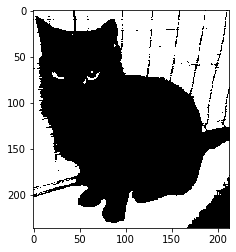

In [3]:
gray_img = cv2.imread('img/kuro_01.jpeg', cv2.IMREAD_GRAYSCALE) # 画像の読み込み
ret, shirokuro_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_OTSU) #閾値を設定して画像を白黒に分ける
plt.gray()
plt.imshow(shirokuro_img);

In [4]:
#白黒画像から黒の割合を算出し黒の割合が50%以上であれば黒猫と判定
image_size = shirokuro_img.size
whitePixels = cv2.countNonZero(shirokuro_img)
blackPixels = image_size - whitePixels
whiteAreaRatio = (whitePixels / image_size) * 100
blackAreaRatio = (blackPixels / image_size) * 100
print("White Area [%] : ", f'{whiteAreaRatio:.02f}')
print("Black Area [%] : ", f'{blackAreaRatio:.02f}')
print()
if blackAreaRatio >= 50:
    print('Judge: black')
else:
    print('Judge: Not black')

White Area [%] :  44.59
Black Area [%] :  55.41

Judge: black


#### 問題点
1. ネコ以外の黒の領域もカウントしている
2. 画像サイズに対してネコが小さいと正しく判定できない

### Case2 背景にマスク処理をして黒の割合で判定(問題点1に対する解決策)

#### 処理手順
1. Case1で読み込んだ画像の色を反転(マスク処理をしやすくするため)
2. HSVに変換し白の領域を抽出
3. 白以外の領域にマスク処理
3. 白のピクセルと黒のピクセルをカウント

#### 判定基準
- 白のピクセルが50%以上であれば黒ネコと判定(色を反転させているため白のピクセルで判定)

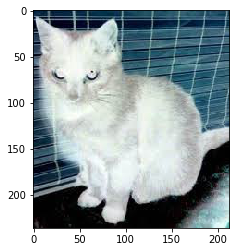

In [5]:
#色を反転させた画像を表示
img_hanten_bgr = cv2.bitwise_not(img_bgr)
img_hanten_rgb = cv2.cvtColor(img_hanten_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_hanten_rgb);

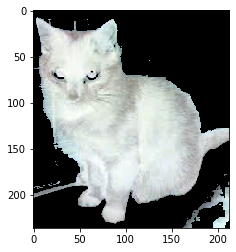

In [6]:
#HSVに変換して白の領域のみ抽出
hsv = cv2.cvtColor(img_hanten_bgr, cv2.COLOR_BGR2HSV)

#白のHSV範囲
lower_white = np.array([0, 0, 100])
upper_white = np.array([180, 45, 255])

#白以外にマスク
mask_white = cv2.inRange(hsv, lower_white, upper_white)
res_white = cv2.bitwise_and(img_hanten_bgr, img_hanten_bgr, mask=mask_white)

#マスク画像表示
res_white_rgb = cv2.cvtColor(res_white, cv2.COLOR_BGR2RGB)
plt.imshow(res_white_rgb);

In [7]:
#白黒画像から白の割合を算出し白の割合が黒よりも大きければ黒猫と判定
img_gray = cv2.cvtColor(res_white, cv2.COLOR_BGR2GRAY)
image_size = img_gray.size
whitePixels = cv2.countNonZero(img_gray)
blackPixels = image_size - whitePixels
whiteAreaRatio = (whitePixels / image_size) * 100
blackAreaRatio = (blackPixels / image_size) * 100
print("White Area [%] : ", f'{whiteAreaRatio:.02f}')
print("Black Area [%] : ", f'{blackAreaRatio:.02f}')
print()
if whiteAreaRatio >= 50:
    print('Judge: black')
else:
    print('Judge: Not black')

White Area [%] :  52.83
Black Area [%] :  47.17

Judge: black


#### 結果
1. 色を反転させることで元画像の黒の領域以外にマスクをかけることができた。
2. マスクをかけることで白と黒の領域の判定の精度がわずかに上がった。

#### 問題点
1. ネコの輪郭以外の領域の白、黒も判定に影響している。(画像右下の白の領域など)
2. 画像に対してネコが小さいと正しく判定できない。

### Case3 輪郭を抽出し輪郭内の色を検査して判定

##### 実装について
- 先に黒色の判定機能を実装する。
- 黒色判定機能を実装後に画像処理機能を実装する。

#### 事前準備
- 手動で背景を白に加工した画像を用意する。

#### 処理手順
1. 画像読み込みグレースケールに変換
2. 2値化し白黒に分ける
3. 輪郭を抽出
4. 周囲長が最長の輪郭内のピクセルを取得
5. 各ピクセルのRGBを検査

#### 判定基準
- 各ピクセルの検査結果、黒と判定されたピクセルが40%以上であれば黒ネコと判定

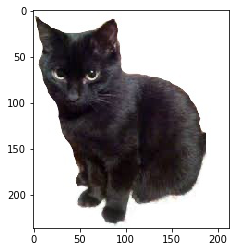

In [8]:
#画像の読み込み
img = cv2.imread('img/neko_1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb);

In [9]:
#グレースケールに変換
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#２値化
retval, bw = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#輪郭を抽出
labels, contours, hierarchy = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

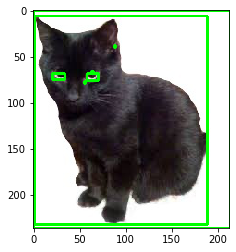

In [10]:
#全ての輪郭を描写
for i in range(0, len(contours)):
    if len(contours[i]) > 0:    
        rect = contours[i]
        x, y, w, h = cv2.boundingRect(rect)
        img_rinkaku = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
img_rinkaku_rgb = cv2.cvtColor(img_rinkaku, cv2.COLOR_BGR2RGB)
plt.imshow(img_rinkaku_rgb);

In [11]:
perimeter_list = []
for i, cnt_i in enumerate(contours):
    #輪郭の周囲長さを計算する
    perimeter = cv2.arcLength(cnt_i, True)
    perimeter_list.append(perimeter)
    
df = pd.DataFrame([perimeter_list]).T
df = df.rename(columns={0:'perimeter'})
df = df.drop(df.index[len(df) - 1]) #最終行は外枠のため除外
contour_max = df['perimeter'].idxmax()
df

,perimeter
0,2.000000
1,34.970562
2,31.556349
3,2.000000
4,2.000000
5,809.068103


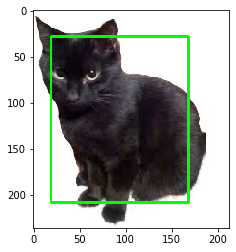

In [12]:
#周囲長さが最長の輪郭を描写
img = cv2.imread('kuro_01_kirinuki.jpg')
rect = contours[contour_max]
x, y, w, h = cv2.boundingRect(rect)

#抽出した輪郭を狭める
x_10 = int(x + w * 0.1)
y_10 = int(y + h * 0.1)
w_20 = int(w * 0.8)
h_20 = int(h * 0.8)

#輪郭を描写
img_res = cv2.rectangle(img, (x_10, y_10), (x_10 + w_20, y_10 + h_20), (0, 255, 0), 2)
img_res_rgb = cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB)
plt.imshow(img_res_rgb);

In [13]:
df_px = pd.DataFrame() #空のデータフレームを作成
for y_px in range(y_10, y_10 + h_20): #y方向に1つずつ検査
    lists_px = []
    for x_px in range(x_10, x_10 + w_20): #x方向に1つずつ検査
        px = img[y_px, x_px] #検査する画素のrgbを取得
        if px[0] <= 50 and px[1] <= 50 and px[2] <= 50: #黒の判定
            lists_px.append(1)
        else:
            lists_px.append(0)
    df_lists_px = pd.DataFrame(lists_px).T
    df_px = df_px.append(df_lists_px)
df_px

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
0,0,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
0,0,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_bool = (df_px == 1)
black_ratio = df_bool.values.sum() / df_px.size * 100
print("ALL Area [px] : ", df_px.size)
print("Black Area [px] : ", df_bool.values.sum())
print("Black Area Ratio [%] : ", f'{black_ratio:.02f}')
if black_ratio >= 40: #40%以上を黒ネコと判定
    print('Judge : black')
else:
    print('Judge : Not black')

ALL Area [px] :  26820
Black Area [px] :  13623
Black Area Ratio [%] :  50.79
Judge : black


#### 結果
- 領域を検出し、その領域内の色を検査し判定をすることができた。

#### 問題点
- 他のネコ画像にもこの判定方向が適用できるか不明。

### Case4 Case3の機能を複数の画像に対して適用

#### 事前準備
- 手動で背景を白に加工した様々なネコ画像を10枚用意

#### 処理手順
Case3と同様

#### 判定基準
Case3と同様

In [15]:
#画像の読み込み
list_img = []
list_img_rgb = []
for i in range(1, 11):
    img = cv2.imread('img/neko_' + str(i) + '.jpg')
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    list_img.append(img_rgb)
    list_img_rgb.append(img_rgb)

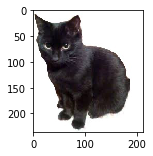

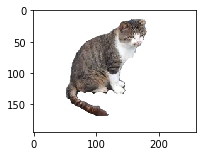

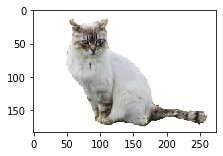

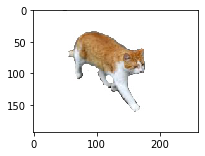

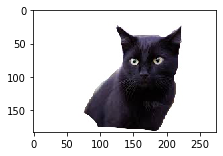

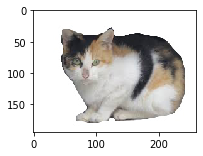

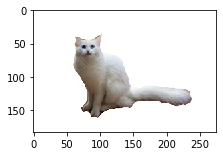

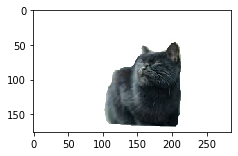

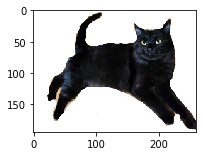

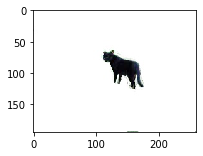

In [16]:
#表示
for i in range(1, 11):
    plt.figure(figsize=(13.0, 13.0))
    plt.subplot(5, 2, i)
    plt.imshow(list_img_rgb[i - 1])

In [17]:
list_gray = []
list_bw = []
for i in range(0, 10):
    #グレースケールに変換
    gray = cv2.cvtColor(list_img[i], cv2.COLOR_BGR2GRAY)
    
    #2値化
    retval, bw = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    list_gray.append(gray)
    list_bw.append(bw)

In [18]:
labels_list = []
contours_list = []
hierarchy_list = []

for i in range(0, 10):
    #輪郭を抽出
    labels, contours, hierarchy = cv2.findContours(list_bw[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    labels_list.append(labels)
    contours_list.append(contours)
    hierarchy_list.append(hierarchy)

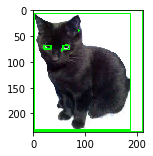

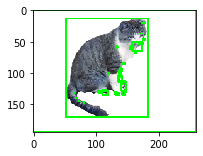

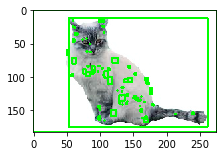

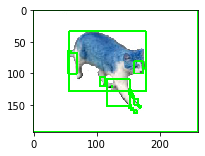

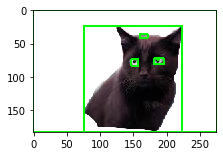

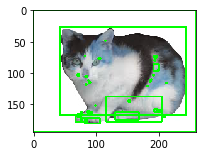

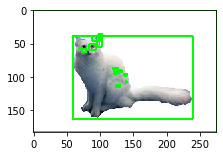

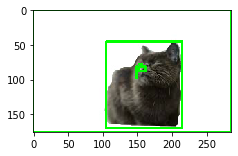

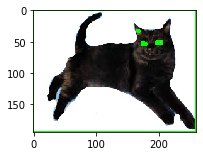

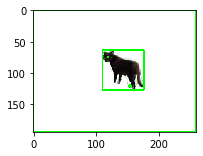

In [19]:
#全ての輪郭を描写
img_rinkaku_list = []
img_rinkaku_rgb_list = []
for i in range(0, 10):
    for j in range(0, len(contours_list[i])):
        if len(contours_list[i][j]) > 0:
            rect = contours_list[i][j]
            x, y, w, h = cv2.boundingRect(rect)
            img_rinkaku = cv2.rectangle(list_img[i], (x, y), (x + w, y + h), (0, 255, 0), 2)
            
    img_rinkaku_rgb = cv2.cvtColor(img_rinkaku, cv2.COLOR_BGR2RGB)
    
    img_rinkaku_list.append(img_rinkaku)
    img_rinkaku_rgb_list.append(img_rinkaku_rgb)

for i in range(1, 11):
    plt.figure(figsize=(13.0, 13.0))
    plt.subplot(5, 2, i)
    plt.imshow(img_rinkaku_rgb_list[i - 1])

#### 問題点
- 尻尾が長い猫は輪郭も大きくとってしまう
- 外枠に猫一部が触れている画像は輪郭を抽出できない

#### Case4 の検討をするための解決策
- 手動で画像を加工し尻尾と外枠に触れている部分をトリミング

In [20]:
#画像の読み込み
list_img = []
list_img_rgb = []
for i in range(1, 11):
    img = cv2.imread('img/m_neko_' + str(i) + '.jpg')
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    list_img.append(img_rgb)
    list_img_rgb.append(img_rgb)

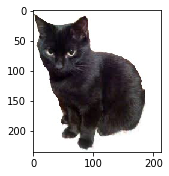

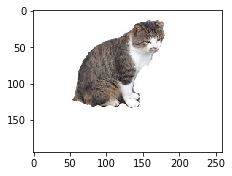

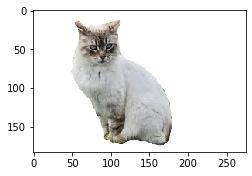

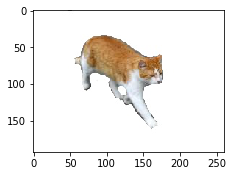

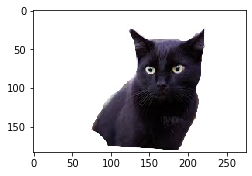

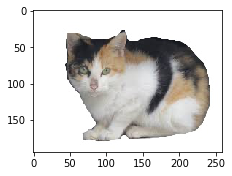

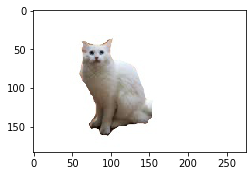

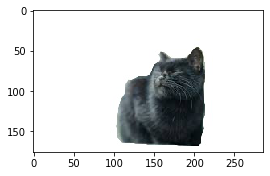

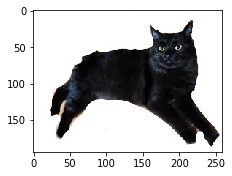

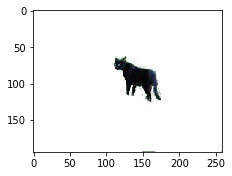

In [21]:
#表示
for i in range(1, 11):
    plt.figure(figsize=(13.0, 13.0))
    plt.subplot(5, 2, i)
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.imshow(list_img_rgb[i - 1])

In [22]:
list_gray = []
list_bw = []
for i in range(0, 10):
    #グレースケールに変換
    gray = cv2.cvtColor(list_img[i], cv2.COLOR_BGR2GRAY)
    
    #2値化
    retval, bw = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    list_gray.append(gray)
    list_bw.append(bw)

In [23]:
labels_list = []
contours_list = []
hierarchy_list = []

for i in range(0, 10):
    #輪郭を抽出
    labels, contours, hierarchy = cv2.findContours(list_bw[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    labels_list.append(labels)
    contours_list.append(contours)
    hierarchy_list.append(hierarchy)

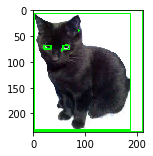

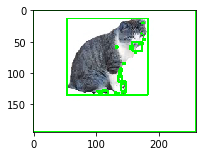

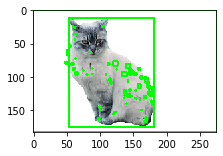

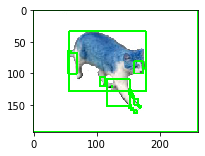

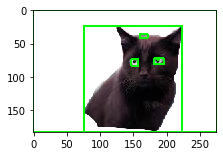

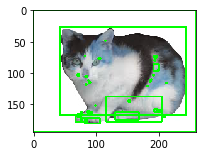

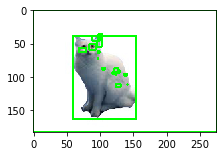

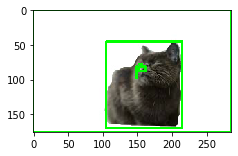

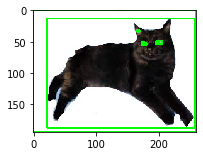

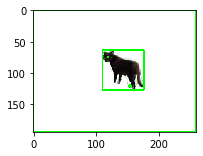

In [24]:
#全ての輪郭を描写
img_rinkaku_list = []
img_rinkaku_rgb_list = []
for i in range(0, 10):
    for j in range(0, len(contours_list[i])):
        if len(contours_list[i][j]) > 0:
            rect = contours_list[i][j]
            x, y, w, h = cv2.boundingRect(rect)
            img_rinkaku = cv2.rectangle(list_img[i], (x, y), (x + w, y + h), (0, 255, 0), 2)
            
    img_rinkaku_rgb = cv2.cvtColor(img_rinkaku, cv2.COLOR_BGR2RGB)
    
    img_rinkaku_list.append(img_rinkaku)
    img_rinkaku_rgb_list.append(img_rinkaku_rgb)

for i in range(1, 11):
    plt.figure(figsize=(13.0, 13.0))
    plt.subplot(5, 2, i)
    plt.imshow(img_rinkaku_rgb_list[i - 1])

##### 画像を加工したことで輪郭を抽出できている

In [25]:
contour_max_list = []
for i in range(0, 10):
    perimeter_list = []
    for i, cnt_i in enumerate(contours_list[i]):
        #輪郭の周囲長さを計算する
        perimeter = cv2.arcLength(cnt_i, True)
        perimeter_list.append(perimeter)
    
    df = pd.DataFrame([perimeter_list]).T
    df = df.rename(columns={0:'perimeter'})
    df = df.drop(df.index[len(df) - 1])
    contour_max = df['perimeter'].idxmax()
    contour_max_list.append(contour_max)

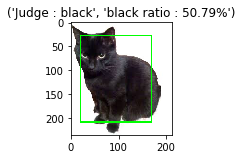

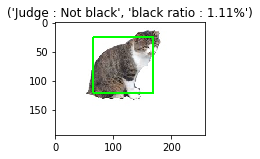

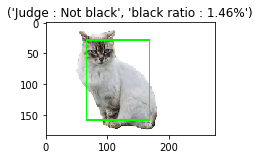

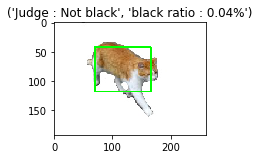

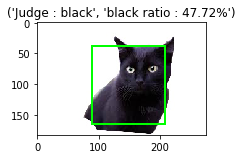

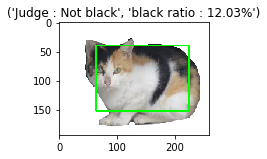

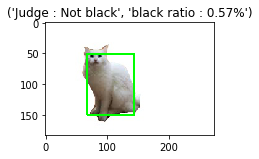

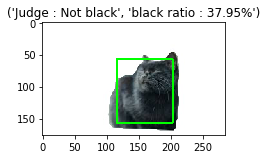

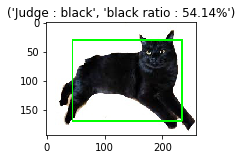

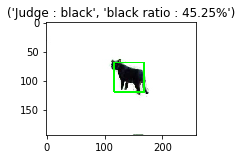

In [27]:
#周囲長さが最長の輪郭を描写
img_res_list = []
img_res_rgb_list = []
black_ratio_list = []
hantei_list = []
for i in range(1, 11):
    img = cv2.imread('img/m_neko_' + str(i) + '.jpg')
    rect = contours_list[i - 1][contour_max_list[i - 1]]
    x, y , w, h = cv2.boundingRect(rect)
    
    #抽出した輪郭を狭める
    x_10 = int(x + w * 0.1)
    y_10 = int(y + h * 0.1)
    w_20 = int(w * 0.8)
    h_20 = int(h * 0.8)
    
    #輪郭を描写
    img_res = cv2.rectangle(img, (x_10, y_10), (x_10 + w_20, y_10 + h_20), (0, 255, 0), 2)
    img_res_rgb = cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB)

    img_res_list.append(img_res)
    img_res_rgb_list.append(img_res_rgb)
    
    df_px = pd.DataFrame() #空のデータフレームを作成
    for y_px in range(y_10, y_10 + h_20): #y方向に1つずつ検査
        lists_px = []
        for x_px in range(x_10, x_10 + w_20): #x方向に1つずつ検査
            px = img[y_px, x_px] #検査する画素のrgbを取得
            if px[0] <= 50 and px[1] <= 50 and px[2] <= 50: #黒の判定
                lists_px.append(1)
            else:
                lists_px.append(0)
        df_lists_px = pd.DataFrame(lists_px).T
        df_px = df_px.append(df_lists_px)
        
    df_bool = (df_px == 1)
    black_ratio = df_bool.values.sum() / df_px.size * 100
    
    black_ratio_list.append(black_ratio)
    if black_ratio >= 40:
        judge = ('Judge : black', 'black ratio : '+f'{black_ratio:.02f}'+'%')
        hantei_list.append(judge)
    else:
        judge = ('Judge : Not black', 'black ratio : '+f'{black_ratio:.02f}'+'%')
        hantei_list.append(judge)

for i in range(1, 11):
    plt.figure(figsize=(12.0, 12.0))
    plt.subplot(5, 2, i)
    plt.title(hantei_list[i - 1])
    plt.imshow(img_res_rgb_list[i - 1]);

#### 結果
- 背景を白、尻尾と画像のはみ出しを除外した画像に対して精度良く輪郭の抽出と黒ネコの判定ができている。
- rgbの判定をチューニングすることでより、精度良く黒ネコを判定できる。

#### 問題点
- 尻尾の取扱が困難(画像処理で尻尾の処理が複雑になる恐れがある)
- ネコの体の一部が画像からはみ出している場合の処理

#### 解決案
- 矩形の輪郭処理ではなく、自由曲線で輪郭を抽出する。
- 一回り大きな背景画像に読み込んだ画像を貼り付けて輪郭を抽出する。